In [ ]:
import pandas as pd


Importation des portefeuilles à une date T
Importation des prix de clôture des titres de l'univers GIP

In [60]:
ALL_Portfolio = pd.read_excel(r'C:\Sharepoint GIP\Gestion Indépendante de patrimoines GIP SA\Docs - Documents\gip sa\Scripts\Risk\Data_Raw\ALL_PORTEFEUILLE_GIP_ANONYME.xlsx')

#Renommer la colonne code portefeuille

ALL_Portfolio = ALL_Portfolio.rename(columns={'Code/Numéro/Contrat': 'Code'})

#IMport liste de titres
#Import closing price

Titres = pd.read_excel(r'C:\Sharepoint GIP\Gestion Indépendante de patrimoines GIP SA\Docs - Documents\datas\Liste Titres CRM\ListeTitres (Pour importation CRM).xlsx')
ALL_CLOSING_Price = pd.read_excel(r'C:\Sharepoint GIP\Gestion Indépendante de patrimoines GIP SA\Docs - Documents\gip sa\Scripts\Risk\Data_Raw\ALL_CLOSE_PRICE_GIP.xlsx')

# Créer un dictionnaire de correspondance entre Code et Libellé
code_to_libelle = ALL_CLOSING_Price.set_index('Code')['Libellé'].to_dict()

Historique_Vol = 20  #remplir dropdown menu datalore

Sélection du portefeuille et calcul des pondération de chaque actif

In [61]:
portfolio_code = 150501

Selected_Portfolio = ALL_Portfolio[
    ALL_Portfolio['Code portefeuille'] == portfolio_code
    ].copy()

 # Calculer la valeur totale du marché du portefeuille sélectionné
total_selected_portfolio = Selected_Portfolio['Valeur marché en  (mon. réf.)'].sum()

# Ajouter la colonne 'Pondération'
Selected_Portfolio['Pondération'] = (
        Selected_Portfolio['Valeur marché en  (mon. réf.)'] / total_selected_portfolio
).round(2)

Selected_Portfolio

,Code portefeuille,Dépositaire,Code gestionnaire,Mode de gestion,Profil de gestion,Catégorie,Genre,Code,Désignation,Taux,...,Prix comptable,Valeur comptable,Prix marché,Valeur marché,Valeur marché en (mon. réf.),Intérêts courus,Intérêts courus en (mon. réf.),PP non réal. en % Orig.,PP non réal. en % (mon. réf.),Pondération
2,150501,Banque Cantonale de Fribourg,GIB,Gestion,Equilibré,Liquidités,Compte cash,30.01.667.641-00,Compte courant,NaN,...,NaN,101842.75,0.00,101842.75,101842.75,0.00,0.00,NaN,NaN,0.29
3,150501,Banque Cantonale de Fribourg,GIB,Gestion,Equilibré,Obligations et assimilés,Obligations,CH1204259787,2.5% Axpo Hldg 22-29,0.0250,...,98.24175,19648.35,103.20,20640.00,20640.00,23.61,23.61,0.0505,0.0505,0.06
4,150501,Banque Cantonale de Fribourg,GIB,Gestion,Equilibré,Obligations et assimilés,Obligations,CH1206367463,1.95% Groupe E 22-27,0.0195,...,101.30350,20260.70,101.50,20300.00,20300.00,197.17,197.17,0.0019,0.0019,0.06
5,150501,Banque Cantonale de Fribourg,GIB,Gestion,Equilibré,Obligations et assimilés,Obligations,CH1210198144,2.717% Clariant Ltd 22-27,0.0272,...,102.15925,20431.85,102.35,20470.00,20470.00,283.78,283.78,0.0019,0.0019,0.06
6,150501,Banque Cantonale de Fribourg,GIB,Gestion,Equilibré,Obligations et assimilés,Obligations,CH1266847131,2.665%Cembra Money Bk 30,0.0267,...,99.76300,24940.75,104.55,26137.50,26137.50,507.09,507.09,0.048,0.048,0.08
7,150501,Banque Cantonale de Fribourg,GIB,Gestion,Equilibré,Actions et assimilés,Actions,CH0003541510,Reg.Shs Forbo Holding Ltd,NaN,...,1150.14000,11501.40,1152.00,11520.00,11520.00,0.00,0.00,0.0016,0.0016,0.03
8,150501,Banque Cantonale de Fribourg,GIB,Gestion,Equilibré,Actions et assimilés,Actions,CH0010645932,Reg.Shs Givaudan SA,NaN,...,3032.55000,6065.10,4016.00,8032.00,8032.00,0.00,0.00,0.3243,0.3243,0.02
9,150501,Banque Cantonale de Fribourg,GIB,Gestion,Equilibré,Actions et assimilés,Actions,CH0012032048,Drc Roche Holding Ltd,NaN,...,289.11500,72278.75,229.70,57425.00,57425.00,0.00,0.00,-0.2055,-0.2055,0.17
10,150501,Banque Cantonale de Fribourg,GIB,Gestion,Equilibré,Actions et assimilés,Actions,CH0012410517,Reg.Shs Baloise-Holding AG,NaN,...,134.41400,6720.70,141.30,7065.00,7065.00,0.00,0.00,0.0512,0.0512,0.02
11,150501,Banque Cantonale de Fribourg,GIB,Gestion,Equilibré,Actions et assimilés,Actions,CH0016440353,Reg.Shs EMS-CHEMIE HOLDING AG,NaN,...,719.90500,7199.05,692.00,6920.00,6920.00,0.00,0.00,-0.0388,-0.0388,0.02


Création d'un dataframe avec les prix historiques des actifs du portefeuille

Collecte des ISIN du portefeuille

In [62]:
ISIN_Selected_Portfolio = Selected_Portfolio['Code'].unique()

ISIN_Selected_Portfolio

array(['30.01.667.641-00', 'CH1204259787', 'CH1206367463', 'CH1210198144',
       'CH1266847131', 'CH0003541510', 'CH0010645932', 'CH0012032048',
       'CH0012410517', 'CH0016440353', 'CH0030170408', 'CH0038863350',
       'CH1243598427', 'CH0139101593'], dtype=object)

Filter le datadframe de l'univers titres

In [64]:
Historical_Price_Selected_Portfolio = ALL_CLOSING_Price[ALL_CLOSING_Price['Code'].isin(ISIN_Selected_Portfolio)]

Historical_Price_Selected_Portfolio = Historical_Price_Selected_Portfolio.drop(columns =['Pr.','Libellé','Abréviation','Monnaie','Genre']).T

# Faire de la ligne "Code" les noms des colonnes
Historical_Price_Selected_Portfolio.columns = Historical_Price_Selected_Portfolio.iloc[0]

Historical_Price_Selected_Portfolio = Historical_Price_Selected_Portfolio[1:]  # Supprimer la ligne devenue les colonnes

# Renommer les colonnes dans Historical_Price_Selected_Portfolio_percent
Historical_Price_Selected_Portfolio.rename(columns=code_to_libelle, inplace=True)

Historical_Price_Selected_Portfolio





Code,Reg.Shs Forbo Holding Ltd,Reg.Shs Givaudan SA,Drc Roche Holding Ltd,Reg.Shs Baloise-Holding AG,Reg.Shs EMS-CHEMIE HOLDING AG,Reg.Shs Geberit AG,Reg.Shs Nestle Ltd.,Ant.-AA (CHF)- ZKB Gold ETF,2.5% Axpo Hldg 22-29,1.95% Groupe E 22-27,2.717% Clariant Ltd 22-27,Reg.Shs Sandoz Group Ltd,2.665%Cembra Money Bk 30
2023-03-31 00:00:00,1322.0,2973.0,260.95,142.4,754.0,509.2,111.46,540.9,98.2,98.4,100.75,NaN,NaN
2023-04-03 00:00:00,1322.0,2985.0,260.3,141.5,753.5,508.4,112.1,544.2,98.2,98.35,100.35,NaN,NaN
2023-04-04 00:00:00,1296.0,2964.0,260.8,142.9,747.0,504.2,111.3,550.1,98.05,98.3,100.55,NaN,NaN
2023-04-05 00:00:00,1288.0,3034.0,267.3,143.2,739.5,482.8,112.84,548.6,98.65,98.4,100.8,NaN,NaN
2023-04-06 00:00:00,1258.0,3087.0,274.5,146.1,744.5,481.9,113.72,545.8,99.15,99.0,101.55,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25 00:00:00,1142.0,4066.0,225.5,139.8,692.0,529.8,94.75,583.1,103.25,101.5,102.1,26.99,104.55
2024-03-26 00:00:00,1138.0,4034.0,227.2,139.5,694.5,533.2,95.48,586.4,103.2,101.5,102.1,26.8,104.8
2024-03-27 00:00:00,1140.0,4015.0,226.75,142.1,687.5,532.8,96.0,591.6,103.35,101.5,102.15,26.6,104.55
2024-03-28 00:00:00,1152.0,4016.0,229.7,141.3,692.0,533.0,95.75,595.9,103.2,101.5,102.35,27.21,104.55


In [65]:
Historical_Price_Selected_Portfolio = Historical_Price_Selected_Portfolio.ffill()

Historical_Price_Selected_Portfolio = Historical_Price_Selected_Portfolio.apply(pd.to_numeric, errors='coerce')

Historical_Price_Selected_Portfolio_percent = Historical_Price_Selected_Portfolio.pct_change(fill_method=None)

Historical_Price_Selected_Portfolio_percent = Historical_Price_Selected_Portfolio_percent.dropna()

Historical_Price_Selected_Portfolio_percent



C:\Users\JulienBaechler\AppData\Local\Temp\ipykernel_8920\3413982562.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Historical_Price_Selected_Portfolio = Historical_Price_Selected_Portfolio.ffill()


Code,Reg.Shs Forbo Holding Ltd,Reg.Shs Givaudan SA,Drc Roche Holding Ltd,Reg.Shs Baloise-Holding AG,Reg.Shs EMS-CHEMIE HOLDING AG,Reg.Shs Geberit AG,Reg.Shs Nestle Ltd.,Ant.-AA (CHF)- ZKB Gold ETF,2.5% Axpo Hldg 22-29,1.95% Groupe E 22-27,2.717% Clariant Ltd 22-27,Reg.Shs Sandoz Group Ltd,2.665%Cembra Money Bk 30
2023-10-05 00:00:00,0.020716,0.001725,0.011273,-0.002338,0.004938,-0.001107,0.000583,-0.006405,0.002521,-0.006015,0.004480,0.030801,-0.000495
2023-10-06 00:00:00,-0.003690,-0.023760,0.005675,0.007031,0.013923,0.008865,-0.025267,0.004130,0.002012,-0.000504,0.000000,-0.001992,0.003469
2023-10-09 00:00:00,0.009259,-0.002469,0.011084,-0.002327,-0.012116,-0.007469,0.010967,0.009329,0.001506,0.007568,0.001982,0.007585,0.001975
2023-10-10 00:00:00,0.016514,0.030764,0.007176,0.002333,0.015536,0.022134,0.018738,-0.000795,0.000501,-0.004507,0.000000,-0.012678,0.000493
2023-10-11 00:00:00,0.003610,-0.007890,0.005541,0.004655,-0.004831,0.001732,0.018006,0.006565,0.006513,0.004527,0.001484,0.033708,0.002463
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25 00:00:00,-0.003490,-0.009501,0.000888,-0.018258,0.004354,-0.010459,0.004133,0.006039,-0.000968,-0.003436,-0.000978,-0.000370,-0.000478
2024-03-26 00:00:00,-0.003503,-0.007870,0.007539,-0.002146,0.003613,0.006418,0.007704,0.005659,-0.000484,0.000000,0.000000,-0.007040,0.002391
2024-03-27 00:00:00,0.001757,-0.004710,-0.001981,0.018638,-0.010079,-0.000750,0.005446,0.008868,0.001453,0.000000,0.000490,-0.007463,-0.002385
2024-03-28 00:00:00,0.010526,0.000249,0.013010,-0.005630,0.006545,0.000375,-0.002604,0.007268,-0.001451,0.000000,0.001958,0.022932,0.000000


Estimation Mean Variance Portfolio

In [66]:

import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Historical_Price_Selected_Portfolio_percent)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,Reg.Shs Forbo Holding Ltd,Reg.Shs Givaudan SA,Drc Roche Holding Ltd,Reg.Shs Baloise-Holding AG,Reg.Shs EMS-CHEMIE HOLDING AG,Reg.Shs Geberit AG,Reg.Shs Nestle Ltd.,Ant.-AA (CHF)- ZKB Gold ETF,2.5% Axpo Hldg 22-29,1.95% Groupe E 22-27,2.717% Clariant Ltd 22-27,Reg.Shs Sandoz Group Ltd,2.665%Cembra Money Bk 30
weights,2.461116e-09,0.147643,1.856240e-09,0.129533,0.023604,2.798971e-09,7.081284e-10,0.325604,0.170277,0.055384,0.106922,0.029774,0.011259


Dessiner la composition du portefeuille

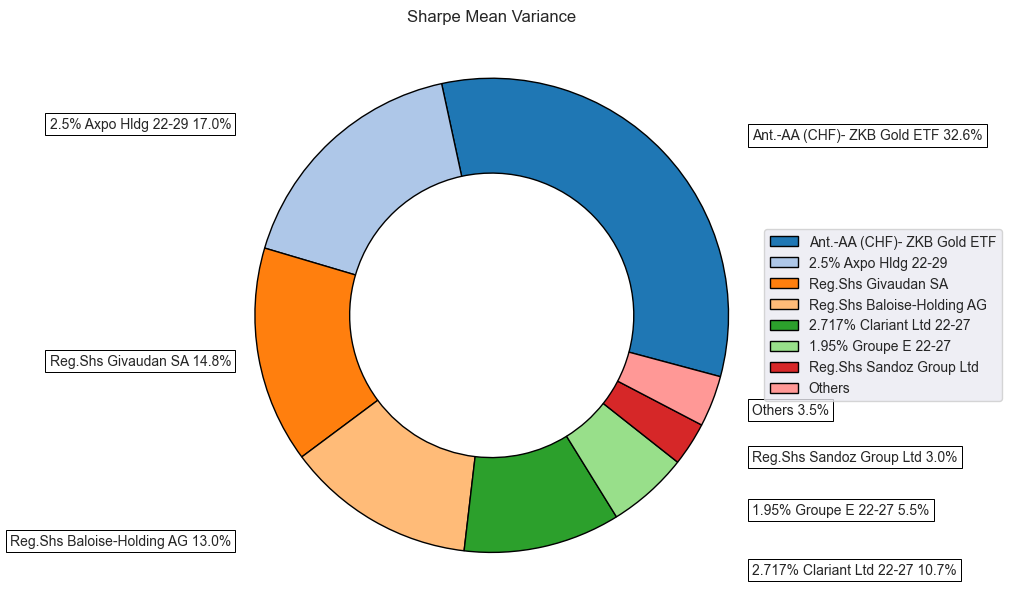

In [67]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

Calculer la frontière efficiente

In [68]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,Reg.Shs Forbo Holding Ltd,Reg.Shs Givaudan SA,Drc Roche Holding Ltd,Reg.Shs Baloise-Holding AG,Reg.Shs EMS-CHEMIE HOLDING AG,Reg.Shs Geberit AG,Reg.Shs Nestle Ltd.,Ant.-AA (CHF)- ZKB Gold ETF,2.5% Axpo Hldg 22-29,1.95% Groupe E 22-27,2.717% Clariant Ltd 22-27,Reg.Shs Sandoz Group Ltd,2.665%Cembra Money Bk 30
0,2.872802e-09,0.006585,1.523815e-02,0.059358,2.214247e-08,3.799621e-09,1.712580e-08,0.039216,0.100897,0.275931,0.247475,0.013290,0.242010
1,1.920006e-09,0.054243,2.421440e-09,0.086225,1.661639e-03,2.280175e-09,1.224585e-09,0.131195,0.123893,0.210017,0.205409,0.021202,0.166155
2,1.515534e-09,0.075563,3.425454e-09,0.096110,6.656972e-03,1.993162e-09,6.421085e-10,0.175560,0.134479,0.174740,0.182933,0.023161,0.130797
3,4.889502e-10,0.093131,6.543554e-10,0.104255,1.078993e-02,5.808204e-10,1.890544e-10,0.212130,0.143203,0.145659,0.164407,0.024773,0.101652
4,4.205499e-09,0.108941,3.736244e-09,0.111585,1.450920e-02,7.007884e-09,7.840995e-10,0.245040,0.151053,0.119489,0.147735,0.026223,0.075425


Dessiner la frontière efficiente

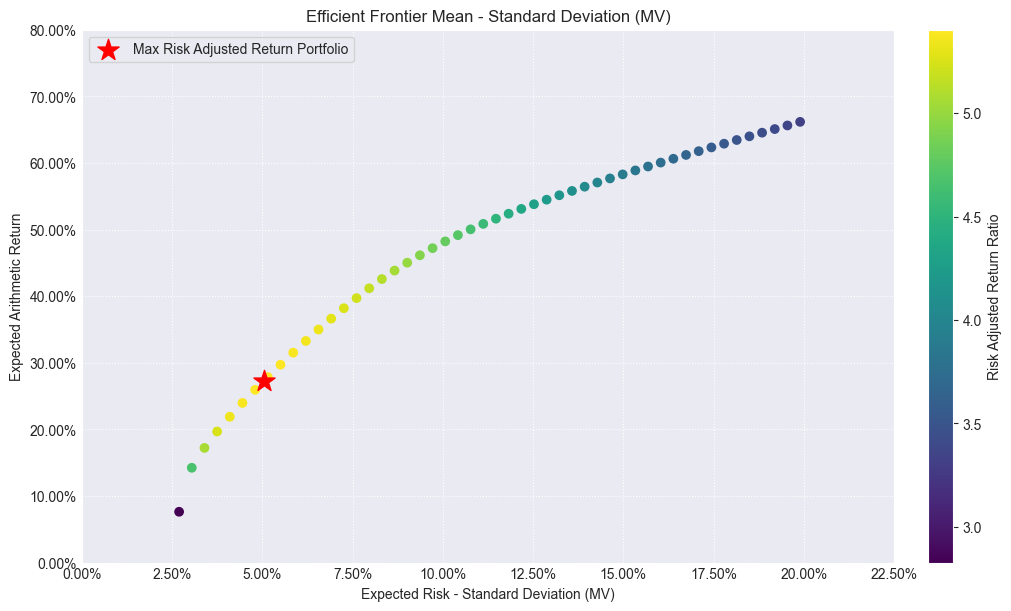

In [69]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

In [71]:
# Calcul des statistiques des actifs
port.assets_stats(method_mu='hist', method_cov='hist')

# Obtenir les moyennes et covariances
mu = port.mu  # Moyennes des rendements (Mean returns)
cov = port.cov  # Matrice de covariance (Variance-Covariance Matrix)

# Affichage
print("Mean Returns (mu):\n", mu)
print("\nCovariance Matrix (cov):\n", cov)


Mean Returns (mu):
    Reg.Shs Forbo Holding Ltd  Reg.Shs Givaudan SA  Drc Roche Holding Ltd  \
0                   0.000742             0.002626              -0.000399   

   Reg.Shs Baloise-Holding AG  Reg.Shs EMS-CHEMIE HOLDING AG  \
0                    0.000785                       0.001067   

   Reg.Shs Geberit AG  Reg.Shs Nestle Ltd.  Ant.-AA (CHF)- ZKB Gold ETF  \
0            0.001419            -0.000506                     0.001399   

   2.5% Axpo Hldg 22-29  1.95% Groupe E 22-27  2.717% Clariant Ltd 22-27  \
0              0.000322               0.00014                   0.000151   

   Reg.Shs Sandoz Group Ltd  2.665%Cembra Money Bk 30  
0                  0.001078                  0.000278  

Covariance Matrix (cov):
                                Reg.Shs Forbo Holding Ltd  Reg.Shs Givaudan SA  \
Reg.Shs Forbo Holding Ltd                   2.158788e-04         1.954996e-05   
Reg.Shs Givaudan SA                         1.954996e-05         1.570160e-04   
Drc Roche Ho

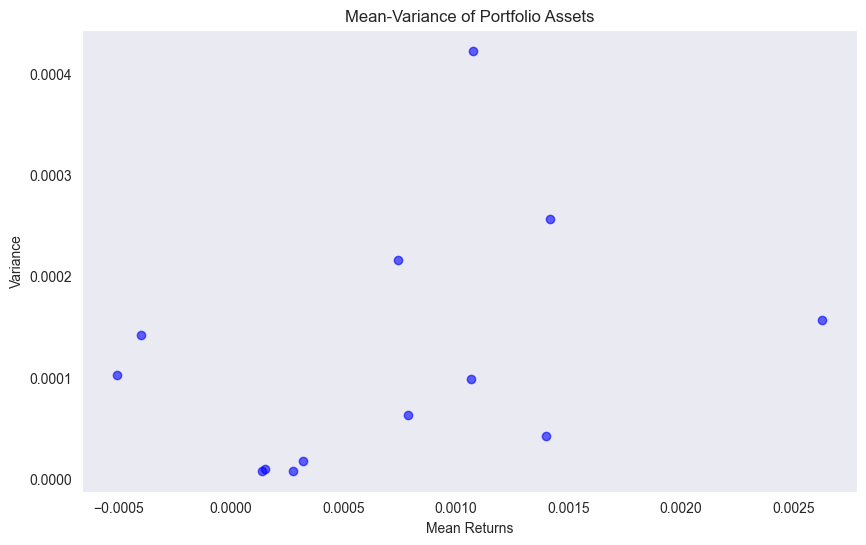